In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [9]:
#load population data

ehr_data = pd.read_csv('/Users/yuhanwang/Documents/gitclones/EHR - Team 6 Project/MemberYear.csv')

In [28]:
X = ehr_data.drop(['Cardiac Event', 
       'Cardiac Arrest', 'History of cardiac arrest (situation)',
       'Atrial Fibrillation', 
       'Coronary Heart Disease',
       'Myocardial Infarction',
       'History of myocardial infarction (situation)','PATIENT'], axis=1)
Y = ehr_data['Cardiac Event']

In [29]:
#Split training and data set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [30]:
#define the value for confusion matrix results
def value_function(y_true, y_pred, tn_value=10, fp_value=-10, fn_value=-100, tp_value=100):
    sum_ = y_pred + y_true
    diff_ = y_pred - y_true
    tn_contrib = tn_value * np.mean((sum_ == 0) & (diff_ == 0))
    fp_contrib = fp_value * np.mean((sum_ == 1) & (diff_ == 1))
    fn_contrib = fn_value * np.mean((sum_ == 1) & (diff_ == -1))
    tp_contrib = tp_value * np.mean((sum_ == 2) & (diff_ == 0))
    return tn_contrib + fp_contrib + fn_contrib + tp_contrib

In [39]:
# Create function for making intervention to patients based on prediction

def intervine_patients(model, X, Y, fp_value=-10, tp_value=100):
    tp_contrib = np.sum((model.predict(X) > 0) & (Y > 0)) * tp_value
    fp_contrib = np.sum((model.predict(X) > 0) & (Y < 1)) * fp_value
    return tp_contrib + fp_contrib

In [31]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize the RFE object with the Random Forest model and the desired number of features to select
rfe = RFE(estimator=rf, n_features_to_select=5)

# Fit RFE to the training data
rfe.fit(X_train, Y_train)

# Get the selected features and their rankings
selected_features = X_train.columns[rfe.support_]
feature_rankings = rfe.ranking_

# Print the selected features and their rankings
for feature, rank in zip(selected_features, feature_rankings):
    print(f"Feature: {feature}, Rank: {rank}")

# Train the Random Forest model on the selected features
rf.fit(X_train[selected_features], Y_train)

# Evaluate the model on the test set
accuracy = rf.score(X_test[selected_features], Y_test)
print(f"Accuracy: {accuracy}")

Feature: Years (MemMonth), Rank: 1
Feature: ambulatory, Rank: 13
Feature: Age, Rank: 8
Feature: ER_Visits, Rank: 16
Feature: Chronic congestive heart failure (disorder), Rank: 12
Accuracy: 0.9683018867924529


In [32]:
# Update data with selected feature 
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


In [43]:
# Update model with selected feature
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, Y_train)

RandomForestClassifier(random_state=42)

In [45]:
# Perform cross-validation and compute accuracy
cv_scores = cross_val_score(rf_selected, X_train_selected, Y_train, cv=5)  # Set the number of folds as desired
mean_accuracy = cv_scores.mean()

print("Cross-Validation Accuracy Scores:")
print(cv_scores)
print("Mean Accuracy:", mean_accuracy)

Cross-Validation Accuracy Scores:
[0.96603774 0.9672956  0.96981132 0.96725441 0.96347607]
Mean Accuracy: 0.9667750265354943


In [47]:
# Compute the value function for the Random 
rf_y_test = rf_selected.predict(X_test_selected)
rf_value = value_function(Y_test,rf_y_test)

rf_impacts = intervine_patients(rf_selected, X_test_selected, Y_test)

rf_impacts

690

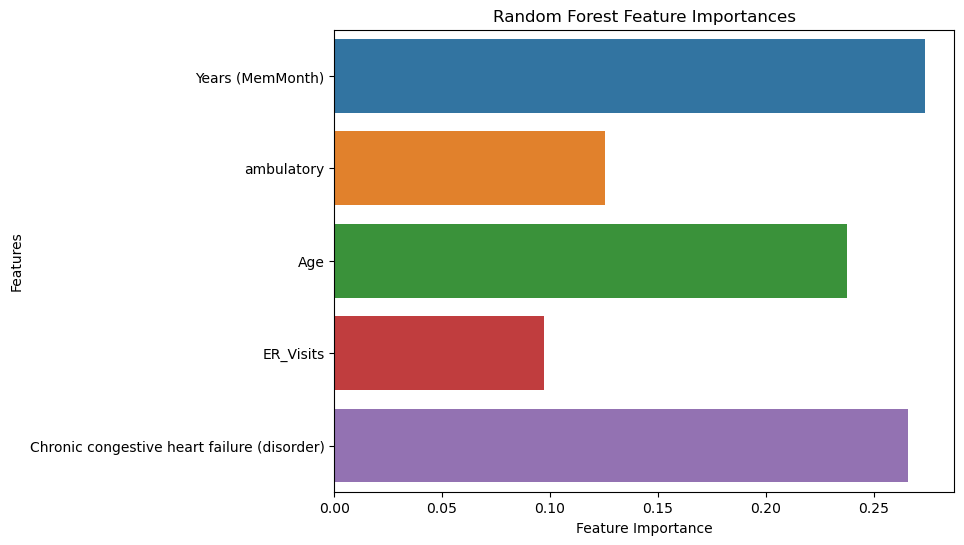

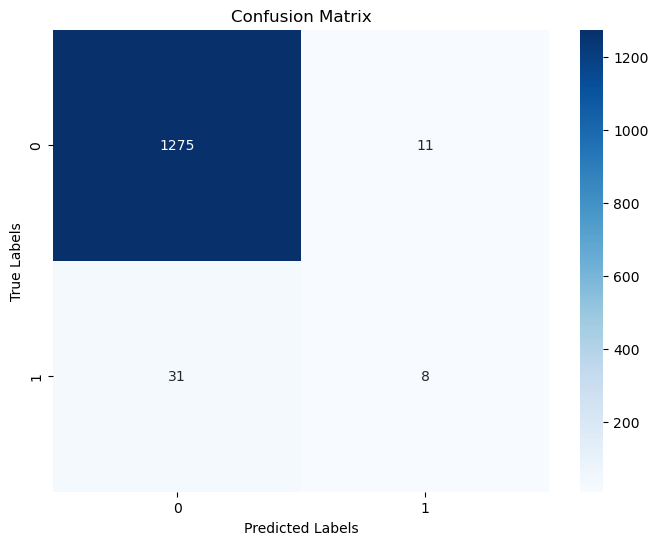

In [51]:
# Visualize feature importances
feature_importances = rf_selected.feature_importances_
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=selected_features)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importances")
plt.show()

# Generate confusion matrix
y_pred = rf_selected.predict(X_test_selected)
cm = confusion_matrix(Y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()